<a href="https://colab.research.google.com/github/daniilpopoff/petprogects/blob/main/F_Baseline_code_KG_3_place.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection kyrgyz alphabet letters


[**Site of competition**](https://thecramer.com/challenges/datathon-november-2022)

The task of the competition is to most accurately recognize the handwritten letters of the Kyrgyz alphabet (36 letters).

Data set of handwritten kyrgyz lellers includes 89117 images sized 50x50 pixels


Data set divided into:

1.   **train/test** = 80213  img
2.   **validation** = 8904 img






\begin{array}{|c|c|} \hline
label & pixel0 & pixel1 & pixel2 & ... & pixe2499 \\ \hline
1 & 0 & 0 & 255 \\
2 & 0 & 0 & 200 \\
4 & 0 & 100 & 190 \\ \hline
\end{array}

## Initialization

In [9]:
# Importing the packages

import os
import random
import logging
import datetime
import collections


# We need this for right print.
from IPython.display import display, Markdown, Image, Latex
import ipywidgets as ipw

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [10]:
# Fix random number generators for reproducibility.
# Fixing method is not complete and does not guarantee 100% reproducibility for this notebook

SEED = 1

random.seed(SEED)
np.random.seed(SEED)

#  create random nubers generator 
RNG = np.random.default_rng()

In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,2,3,4"

In [12]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7983879437935767233
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15094591490177067728
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

## Supporting functions

In [25]:
  # Show the pictures.
def display_examples(examples_number, data_number, image_getter, label_getter=lambda j: ''):
    examples_number = min(examples_number, data_number)
    
    plt.figure(figsize = (16, 16))

    for i, j in enumerate(RNG.choice(data_number, examples_number, replace=False)):
      # print(i, j)
      # print(image_getter(j))
      plt.subplot(1, examples_number, i+1)
      plt.imshow(image_getter(j), cmap=plt.get_cmap('gray'))
      plt.title(label_getter(j))
        
  

## Getting data

In [15]:
# raw_train_test_data.to_csv('train_test.csv', index=False, header=True)

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# %cd /content/drive/My Drive/datathon/

In [18]:
FILE_TRAIN = r'/content/drive/MyDrive/datathon/train_test.csv'

FILE_VALIDATION = r'/content/drive/MyDrive/datathon/validation_with_image_id.csv'

raw_train_data = pd.read_csv(FILE_TRAIN)

display(raw_train_data.shape)
display(raw_train_data)

(80213, 2501)

,label,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_2490,pixel_2491,pixel_2492,pixel_2493,pixel_2494,pixel_2495,pixel_2496,pixel_2497,pixel_2498,pixel_2499
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80208,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80209,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80210,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80211,28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
raw_train_data.max()

label          36
pixel_0        16
pixel_1        85
pixel_2        68
pixel_3       100
             ... 
pixel_2495    102
pixel_2496     79
pixel_2497     73
pixel_2498     26
pixel_2499     20
Length: 2501, dtype: int64

## look at the data

In [20]:
#we need this to make the code more resistant to changes

IMAGE_SIZE = 50
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)

### Train

In [21]:
# separate the values ​​of inputs and outputs and perform basic data preparation for TRAIN

def prepair_x(raw_x):
    x = raw_x.values.astype('float32') / 255
    return x.reshape(x.shape[0], *IMAGE_SHAPE)
    
def prepair_y(raw_y):
    y = raw_y - 1
    return y
    
input_train_x = prepair_x(raw_train_data.iloc[:,1:])
input_train_y = prepair_y(raw_train_data.iloc[:,0].values.astype('int32'))

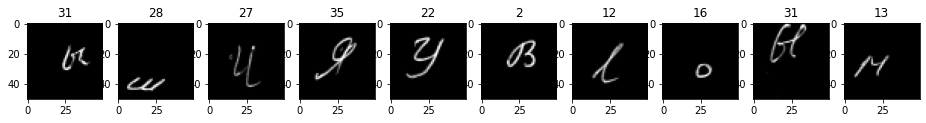

In [22]:
# look at the pictures
display_examples(examples_number=10, 
                 data_number=len(input_train_x), 
                 image_getter=lambda j: input_train_x[j], 
                 label_getter=lambda j: input_train_y[j]) 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


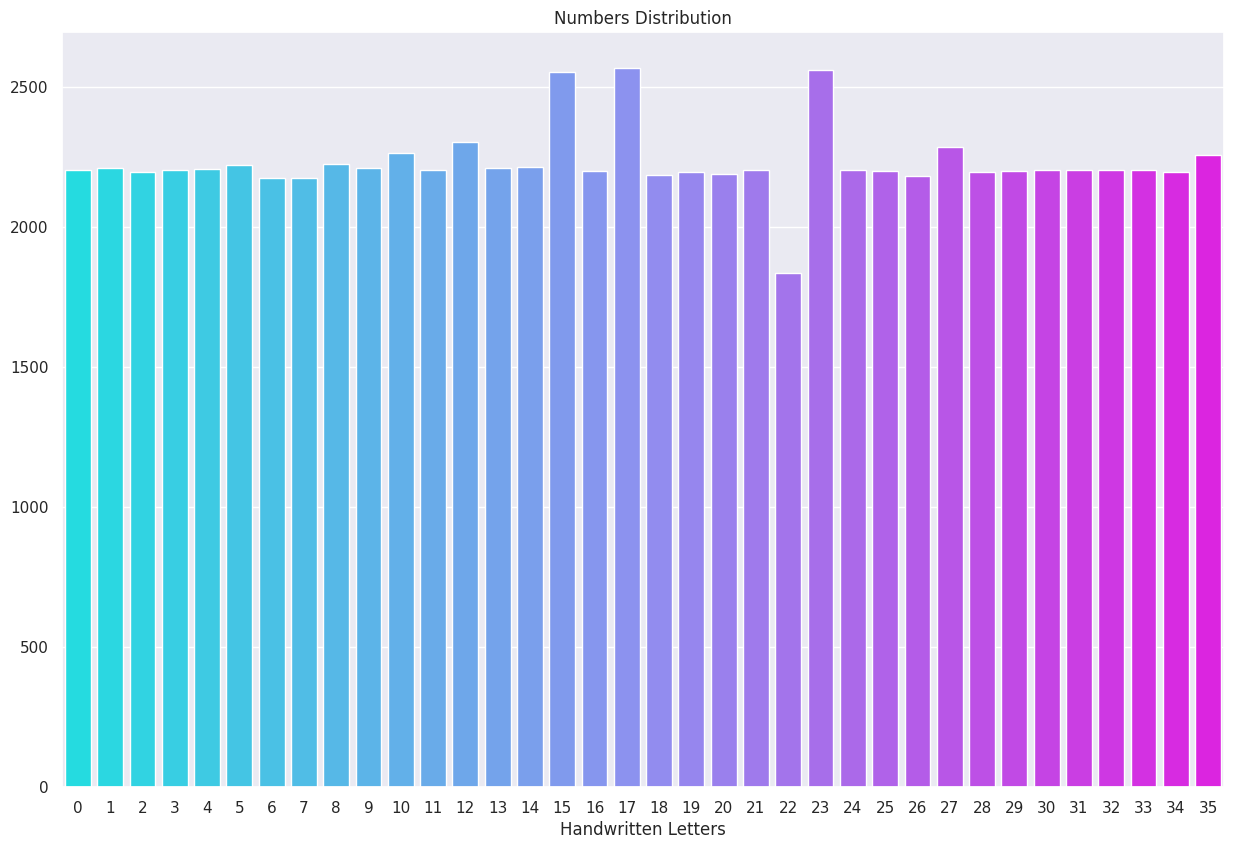

In [23]:
# look at the distribution of pictures by letters

sns.set(rc={'figure.figsize':(15, 10)})

value_count_training = collections.Counter(input_train_y)

fig, ax0 = plt.subplots(1, 1, dpi=100)
ax = sns.barplot(list(value_count_training.keys()), list(value_count_training.values()), palette='cool')
ax.set_xlabel('Handwritten Letters')
ax.set_title("Numbers Distribution")
plt.show()



## Train the model

In [27]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00


In [50]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(input_train_x, input_train_y, test_size=0.2, random_state=1)

In [52]:
num_classes = 36

In [53]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [34]:
y_test.min()

0.0

In [35]:
y_test.max()

1.0

In [37]:
model = keras.Sequential(
    [
        keras.Input(shape=[*IMAGE_SHAPE, 1]),
        layers.Conv2D(32, kernel_size=(3, 3), activation=layers.LeakyReLU(alpha=0.2)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation=layers.LeakyReLU(alpha=0.2)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(128, kernel_size=(3, 3), activation=layers.LeakyReLU(alpha=0.2)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), activation=layers.LeakyReLU(alpha=0.2)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.4),
        layers.Flatten(),
     
        # layers.Dense(1024, activation="relu"),
        layers.Dense(1024, activation=layers.LeakyReLU(alpha=0.2)),
        layers.Dense(512, activation=layers.LeakyReLU(alpha=0.2)),
        layers.Dense(256, activation=layers.LeakyReLU(alpha=0.2)),
        layers.Dense(128, activation=layers.LeakyReLU(alpha=0.2)),

        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 11, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         7

In [39]:
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-0, 1e-1, 1e-2])
# lr and wd can be a function or a tensor
lr = 1e-1 * schedule(step)
wd = lambda: 1e-4 * schedule(step)

batch_size = 128
epochs = 25

model.compile(
    loss="categorical_crossentropy", 
    optimizer=tfa.optimizers.AdamW(weight_decay=wd),
    metrics=["accuracy"])

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/25
452/452 [==============================] - 10s 19ms/step - loss: 1.7066 - accuracy: 0.4867 - val_loss: 0.5278 - val_accuracy: 0.8365
Epoch 2/25
452/452 [==============================] - 7s 15ms/step - loss: 0.5085 - accuracy: 0.8410 - val_loss: 0.3046 - val_accuracy: 0.9081
Epoch 3/25
452/452 [==============================] - 7s 15ms/step - loss: 0.3547 - accuracy: 0.8887 - val_loss: 0.2346 - val_accuracy: 0.9271
Epoch 4/25
452/452 [==============================] - 7s 15ms/step - loss: 0.2885 - accuracy: 0.9085 - val_loss: 0.2196 - val_accuracy: 0.9314
Epoch 5/25
452/452 [==============================] - 7s 15ms/step - loss: 0.2463 - accuracy: 0.9227 - val_loss: 0.1833 - val_accuracy: 0.9431
Epoch 6/25
452/452 [==============================] - 7s 15ms/step - loss: 0.2116 - accuracy: 0.9325 - val_loss: 0.1759 - val_accuracy: 0.9469
Epoch 7/25
452/452 [==============================] - 7s 15ms/step - loss: 0.1972 - accuracy: 0.9372 - val_loss: 0.1741 - val_accuracy: 0.950

In [40]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
126/126 [==============================] - 1s 7ms/step - loss: 0.1059 - accuracy: 0.9704
test loss, test acc: [0.10590579360723495, 0.9703920483589172]
Generate predictions for 3 samples
1/1 [==============================] - 0s 178ms/step
predictions shape: (3, 36)


In [41]:
def one_hot_to_pred(one_hot):
    xr = (np.argmax(one_hot, axis=1) + 1).reshape(-1, 1)
    return xr

## Prepairing data before uploading to the site 

In [42]:
# Look at the data 
raw_validation_data = pd.read_csv(FILE_VALIDATION)

display(raw_validation_data.shape)
display(raw_validation_data)

(8904, 2501)

,id,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_2490,pixel_2491,pixel_2492,pixel_2493,pixel_2494,pixel_2495,pixel_2496,pixel_2497,pixel_2498,pixel_2499
0,276f619c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8ced6677,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,af549c74,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,59170e1b,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ac25b7f0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8899,7ee547cf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8900,dfc2f44d,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8901,543715a7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8902,47d51e67,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# predict 
SUBMISSION_FILE = 'my_submissionf5.csv'

data_for_prediction = prepair_x(raw_validation_data.iloc[:,1:])

predictions = model(data_for_prediction)

In [44]:
predictions

<tf.Tensor: shape=(8904, 36), dtype=float32, numpy=
array([[6.8573511e-13, 1.2232591e-13, 1.5447309e-14, ..., 5.3376205e-12,
        1.9039177e-15, 8.2384837e-12],
       [9.4071417e-10, 7.8538802e-09, 3.0207038e-11, ..., 3.4164861e-12,
        6.1846022e-09, 2.1714388e-07],
       [1.6907818e-09, 2.3656712e-09, 4.9337068e-10, ..., 5.3744418e-09,
        2.9374655e-10, 2.1457396e-08],
       ...,
       [2.7019603e-13, 2.6498065e-16, 3.5538228e-16, ..., 9.9999988e-01,
        6.2325725e-13, 3.1096156e-10],
       [4.8039484e-16, 1.1321891e-11, 9.8919303e-11, ..., 9.1517328e-15,
        2.6387098e-13, 6.1138762e-13],
       [2.9239195e-07, 9.9205071e-12, 1.8228128e-08, ..., 5.2440163e-09,
        3.4566046e-06, 4.7335909e-09]], dtype=float32)>

In [45]:
pred = one_hot_to_pred(predictions).flatten()

In [46]:
pred

array([21, 11, 21, ..., 34,  7, 15])

In [47]:
# transfer data to CSV format 
submissions=pd.DataFrame({"id": raw_validation_data['id'].values,
                          "label": pred})


In [49]:
submissions.to_csv(SUBMISSION_FILE, index=False, header=True)